<a href="https://colab.research.google.com/github/Jflorez05/Especializacion-Analitica/blob/main/Taller%201a%20Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


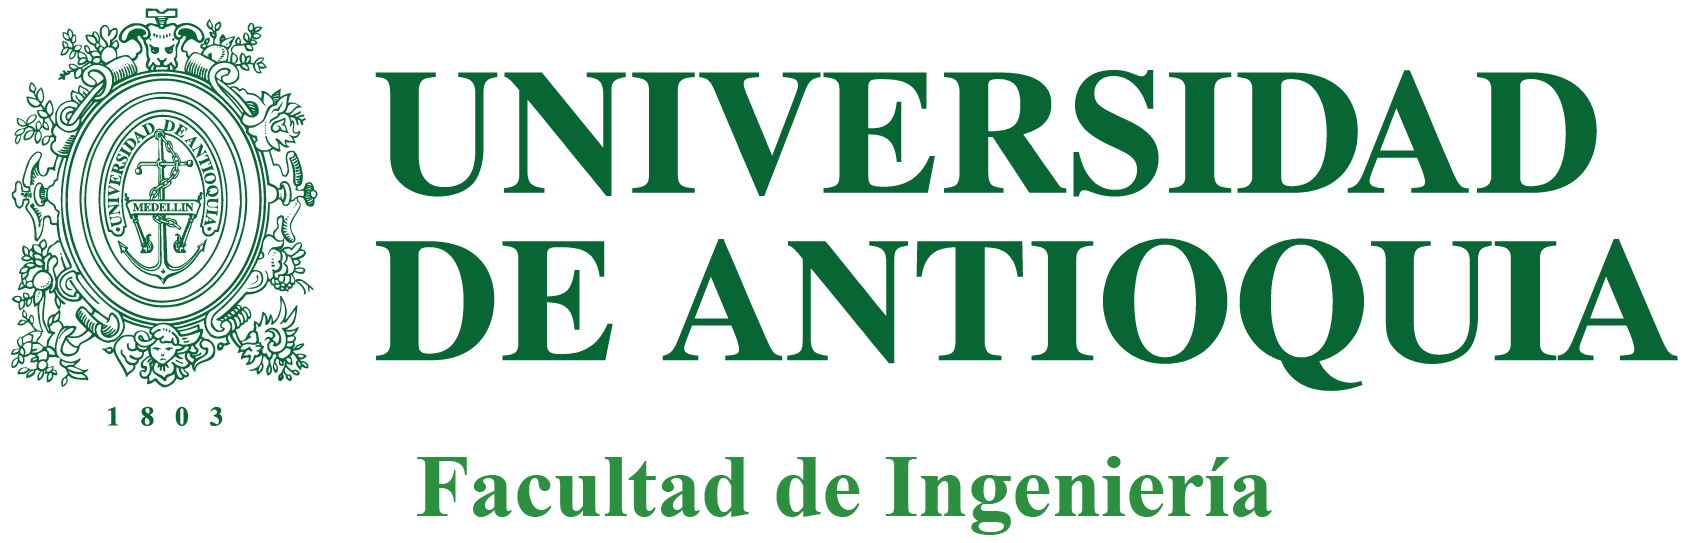
---
- **Asignatura:** Deep Learning
- **Profesor:** Hernán Felipe García Arias
- **Especialización en Analítica y Ciencia de Datos**
- **UdeA**
- **2024-2**

---

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

replicating local resources


In [2]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

setting tensorflow version in colab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.17.0'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [4]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print("dimension de las imagenes y las clases", X.shape, y.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)


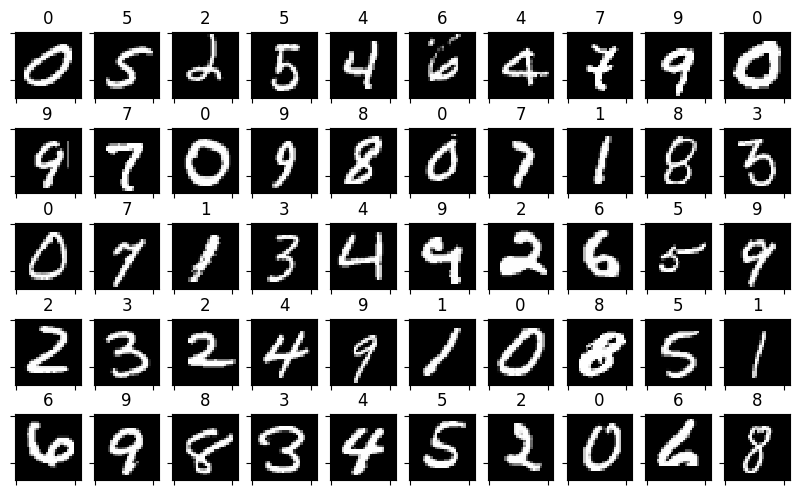

In [5]:
perm = np.random.permutation(list(range(X.shape[0])))[0:50]
random_imgs   = X[perm]
random_labels = y[perm]
fig = plt.figure(figsize=(10,6))
for i in range(random_imgs.shape[0]):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(random_imgs[i].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(int(random_labels[i]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Autoencoder with small (sparse) activations

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [7]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l1
import tensorflow as tf

## Implement the following loss function

given:

- $k=50$, latent dimension
- $\mathbf{x}^{(i)} \in \mathbb{R}^{784}$
- $e(\mathbf{x}^{(i)}) \in \mathbb{R}^{k}$, the encoder
- $d(e(\mathbf{x}^{(i)})) \in \mathbb{R}^{784}$, the decoder

implement the following cost function

$$\text{loss}(\mathbf{x}^{(i)}) = \frac{1}{m}\sum_m \big(\mathbf{x}^{(i)} - d(e(\mathbf{x}^{(i)}))\big)^2 + \beta \frac{1}{k}\sum_{k,i} e(\mathbf{x}^{(i)})$$


In [8]:
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import tensorflow as tf

class CustomLossLayer(Layer):
    def __init__(self, beta=1.0, **kwargs):
        super(CustomLossLayer, self).__init__(**kwargs)
        self.beta = beta

    def call(self, inputs):
        original, decoded, encoder_output = inputs
        # 1. Cálculo del error de reconstrucción (MSE)
        mse_loss = tf.reduce_mean(tf.square(original - decoded))
        # 2. Término de regularización sobre las activaciones del encoder
        regularization_loss = tf.reduce_mean(tf.abs(encoder_output))
        # 3. Función de pérdida total
        total_loss = mse_loss + self.beta * regularization_loss

        self.add_loss(total_loss)  # Agregar la pérdida al modelo

        return decoded  # Retorna la imagen decodificada sin modificación

def get_model(input_dim, code_size, beta=0.01):

    # Define the autoencoder layers
    inputs = Input(shape=(input_dim,), name="input")
    encoder = Dense(code_size, activation='relu', name="encoder")(inputs)
    outputs = Dense(input_dim, activation='sigmoid', name="output")(encoder)

    #avg_latent_activations = tf.reduce_mean(encoder, axis=1)
    custom_loss_layer = CustomLossLayer(beta=beta, name = "loss_with_regularizer")([inputs, outputs, encoder])
    model = Model(inputs, custom_loss_layer)
    model.compile(optimizer='adam')

    return model, encoder

In [9]:
# Parámetros del modelo
input_dim = 784  # Ejemplo: tamaño de imagen 28x28 aplanada
code_size = 50   # Dimensión de la capa latente

# Crear el modelo
model, encoder = get_model(input_dim, code_size)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 784)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Dense)           │ (None, 50)             │         39,250 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 784)            │         39,984 │ encoder[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ loss_with_regularizer     │ (None, 784)            │              0 │ input[0][0],           │
│ (CustomLossLayer)         │                        │                │ output[0][0],          │
│                           │                        │                │ encoder[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 79,234 (309.51 KB)

 Trainable params: 79,234 (309.51 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model, encoder = get_model(input_dim=X.shape[1], code_size=50, beta=0.001)

try with larger layer, try with more layers

In [11]:
model.fit(X_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1893
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0733
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0646
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0569
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0504
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0458
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0428
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0396
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0376
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0357
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0341
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0323
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0285
Epoc

###  test the reconstruction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


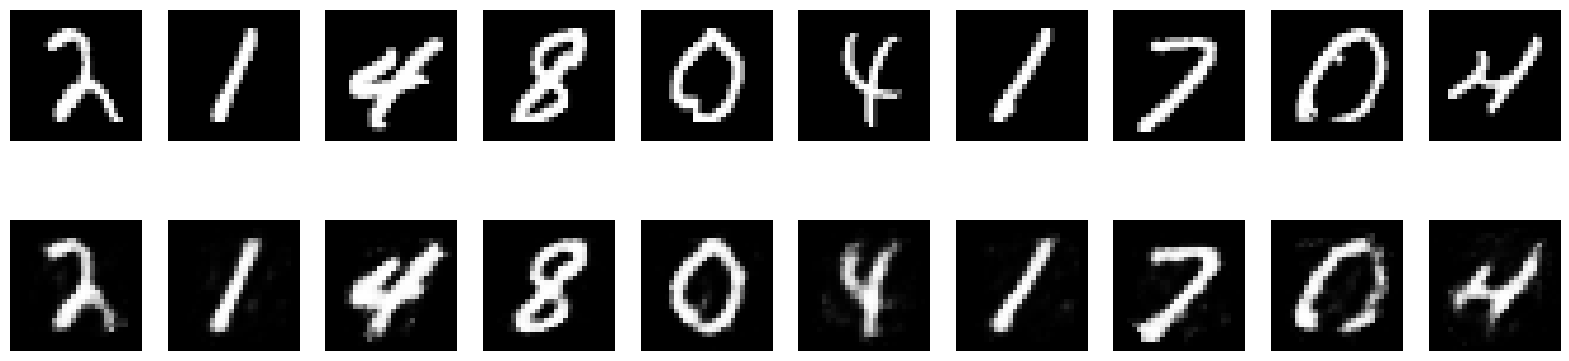

In [14]:
X_sample = np.random.permutation(X_test)[:10]
X_pred   = model.predict(X_sample)

plt.figure(figsize=(20,5))
for i in range(len(X_sample)):
    plt.subplot(2,len(X_sample),i+1)
    plt.imshow(X_sample[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(2,len(X_sample),len(X_sample)+i+1)
    plt.imshow(X_pred[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")

In [21]:
for layer in model.layers:
    print(layer.name)

input
encoder
output
loss_with_regularizer


## **Show the weights**
- Se muestran los pesos para la parte de Encoder y tambien para el decoder.

In [44]:
# Obtener los pesos del modelo entrenado
w = model.get_weights()

print("Listado de los pesos en el entrenamiento:")
# Iterar a través de la lista de pesos del modelo
for i, wi in enumerate(w):
    # Mostrar el índice de la capa, la forma de los pesos y la suma de sus valores
    print(f"weights {i}: {str(wi.shape):10s} sum {np.sum(wi):+6.2f}")

print("\nListado de los pesos por las capas del modelo:")
# Iterar sobre todas las capas del modelo
for i, li in enumerate(model.layers):
    # Imprimir información sobre cada capa: su índice, las formas de sus pesos y la suma de cada uno de los pesos
    print("layer", i, ", ".join([(str(wi.shape) + " sum %+6.2f" % (np.sum(wi.numpy()))) for wi in li.weights]))


Listado de los pesos en el entrenamiento:
weights 0: (784, 50)  sum +592.76
weights 1: (50,)      sum +14.60
weights 2: (50, 784)  sum -1797.62
weights 3: (784,)     sum -135.79

Listado de los pesos por las capas del modelo:
layer 0 
layer 1 (784, 50) sum +592.76, (50,) sum +14.60
layer 2 (50, 784) sum -1797.62, (784,) sum -135.79
layer 3 


## Se muestran graficamente los pesos en las capas de encoder y output.

Pesos en la capa de codificación y salida de decodificación


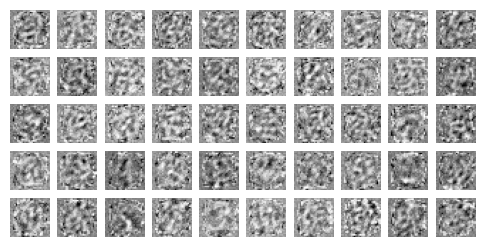

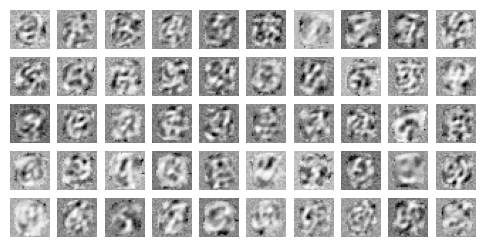

In [45]:
def show_img_grid(w):
    plt.figure(figsize=(6,6))
    for k,wi in enumerate(w):
        plt.subplot(10,10,k+1)
        plt.imshow(wi.reshape(28,28), cmap=plt.cm.Greys_r)
        plt.axis("off")

print("Pesos en la capa de codificación y salida de decodificación")
show_img_grid(model.get_layer("encoder").weights[0].numpy().T)

show_img_grid(model.get_layer("output").weights[0].numpy())

## **Show activations in latent space**

you should get something similar to this, indicating a much more sparse representation

- Se representan las activaciones en las 50 neuronas que representan el espacio latente para cada una de las clases, se puede notar las diferencías notables entre clases y como se separan estas activaciones.

tf.Tensor(
[[3.7603526  4.255703   0.41471565 0.         0.         4.3634562
  0.15770721 2.973041   1.9157448  4.3222017  0.6214461  1.6750579
  4.723359   1.4488456  1.5495445  0.         4.73943    0.
  2.2622416  2.7852137  3.9812098  4.534343   3.7867012  0.48617923
  5.8090897  1.015591   3.3904047  2.4728303  8.078653   2.3874543
  1.8958218  1.3034799  0.15612912 0.9736309  0.         1.1016803
  7.51435    3.863161   0.         6.041649   1.5412534  0.18834525
  0.         6.119531   2.8337746  1.3826451  3.9168634  5.39416
  2.1894066  0.904913  ]], shape=(1, 50), dtype=float32)


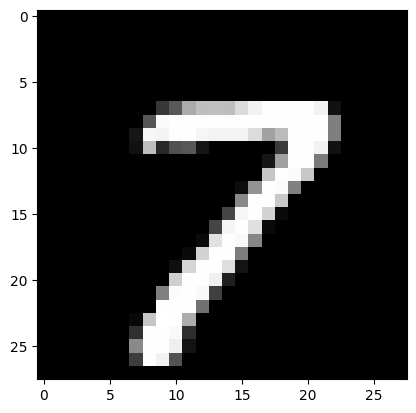

In [26]:
from tensorflow.keras import backend as K
#from tensorflow.keras import Model

layer_input = model.input  # Obtiene la entrada del modelo directamente
layer_encoder = model.layers[1]  # La capa de codificación (ajusta si es necesario)

# Crear el nuevo modelo
me = tf.keras.Model(inputs=layer_input, outputs=layer_encoder.output)

# Ejecutar el modelo en los datos de entrada
e = me(X_train)

# Inspección de datos en el espacio latente (puedes cambiarlo para tu caso específico)
img = np.random.permutation(X_test)[:1]
e = me(img)

# Mostrar el resultado de la codificación
print(e)

# Si 'e' es un tensor, puedes convertirlo en un array de numpy si es necesario
e_numpy = e.numpy()

# Visualizar la imagen original
plt.imshow(img.reshape(28, 28), cmap=plt.cm.Greys_r)
plt.show()

Text(0, 0.5, 'activation (ReLU)')

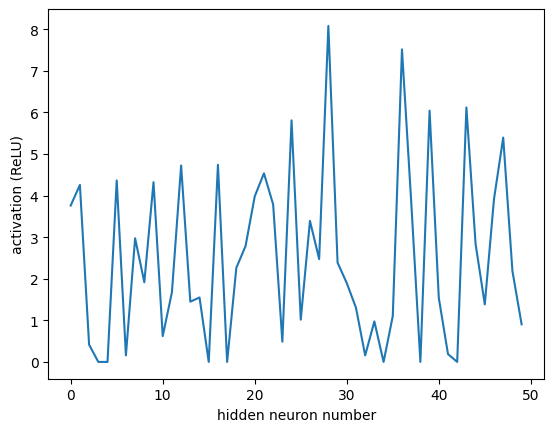

In [46]:
# Graficar la activación de las neuronas en la capa oculta
plt.plot(e[0])  # Graficar las activaciones de la primera muestra (e[0])
plt.xlabel("hidden neuron number")  # Etiqueta del eje X: número de neuronas en la capa oculta
plt.ylabel("activation (ReLU)")  # Etiqueta del eje Y: valor de la activación (suponiendo que se usa ReLU)

encoded data size (200, 50)
mean activation at encoder 2.636


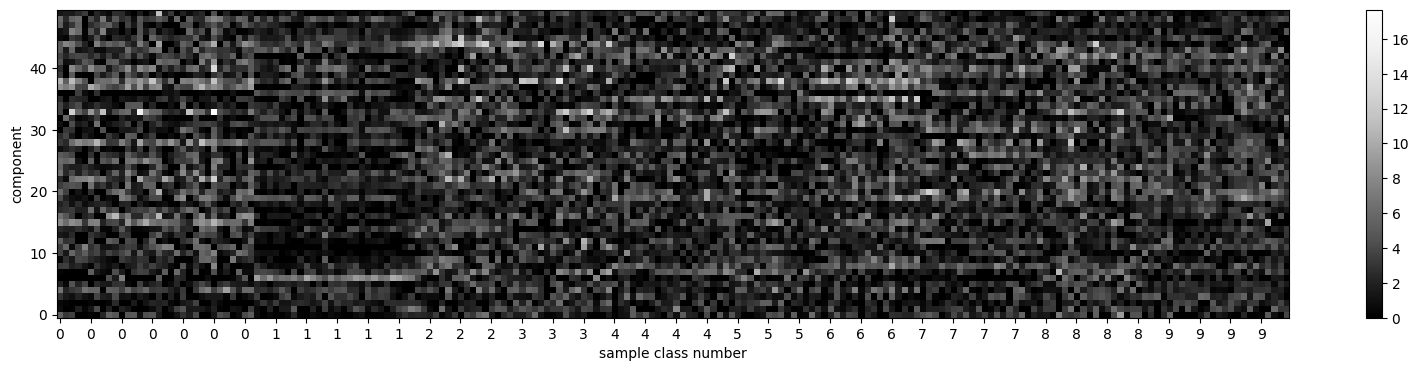

In [48]:
idxs = np.random.permutation(len(X_test))[:200]
idxs = idxs[np.argsort(y_test[idxs])]
y_sample = y_test[idxs]
X_sample = X_test[idxs]

X_sample_encoded = me([X_sample]).numpy()
print("encoded data size", X_sample_encoded.shape)
plt.figure(figsize=(20,4))
plt.imshow(X_sample_encoded.T, cmap=plt.cm.Greys_r, origin="lower")
plt.colorbar()
plt.ylabel("component")
plt.xlabel("sample class number")
plt.xticks(range(len(y_sample))[::5], y_sample[::5]);
print ("mean activation at encoder %.3f"%np.mean(X_sample_encoded))

### show the distribution of activations in latent space

should be quite concentrated at 0

- Se muestran la distribución de las activaciones que efectivamente están concentradas en cero, con esto se nota que muchas de las neuronas tienen una activación muy baja, en este caso la función de perdida tiene un parametro de regularización lo que tambien puede indicar afectación en la activación.

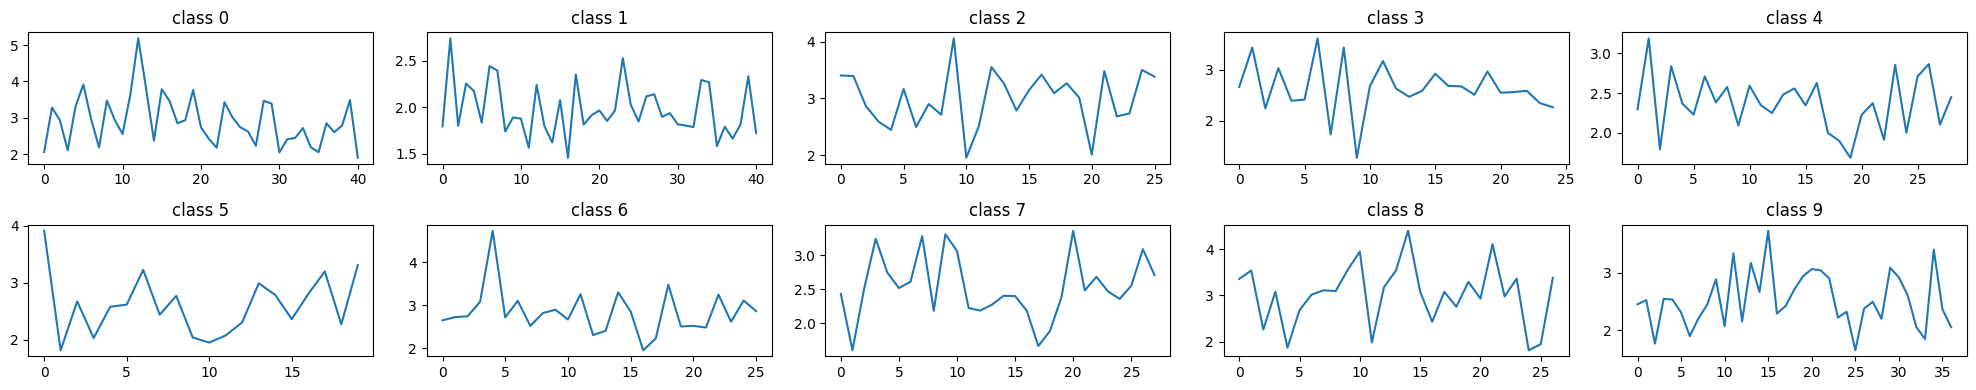

In [50]:
# Obtener las activaciones latentes del modelo para el conjunto de test
e = me(X_test).numpy()

plt.figure(figsize=(20,4))
# Iterar sobre cada clase
for i in range(10):
    # Crear un subgráfico para cada clase (2 filas, 5 columnas)
    plt.subplot(2, 5, i + 1)
    # Calcular la activación promedio de las neuronas en el espacio latente para las muestras de la clase i
    plt.plot(e[y_test == i].mean(axis=1))
    # Añadir un título indicando el número de clase
    plt.title(f"class {i}")

# Ajustar el espacio entre los subgráficos para que no se sobrepongan
plt.tight_layout()

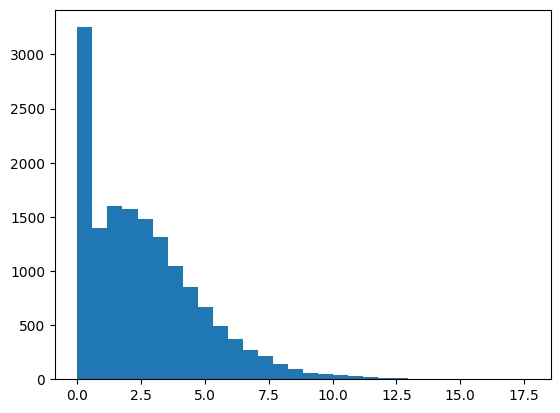

In [51]:
plt.hist(e.flatten(), bins=30);

### show most representative neuron in latent space for each class

now, representative neurons must show somewhat distinctive shapes for each number


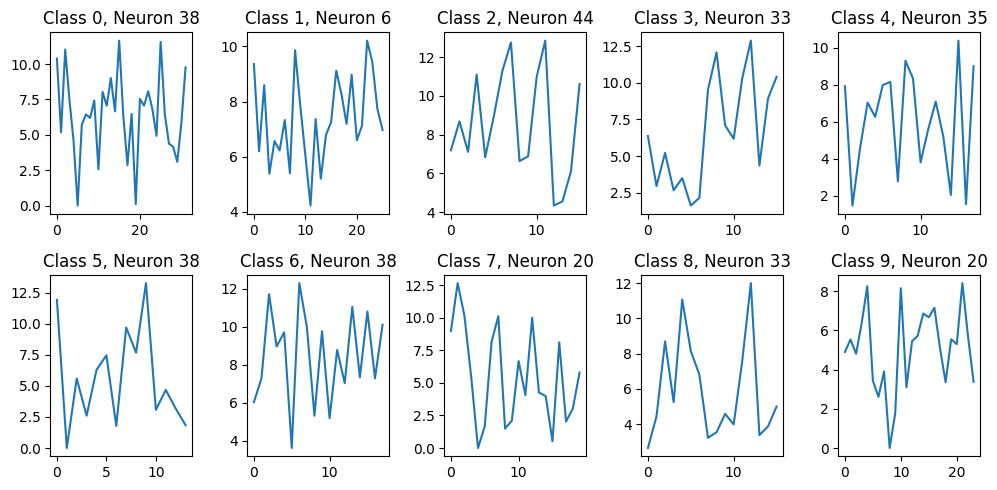

In [52]:
# prompt: Mostrar la neurona mas representativa en el espacio latente para cada una de las clases

# Obtener las activaciones latentes para cada clase
latent_activations_by_class = [X_sample_encoded[y_sample == i] for i in range(10)]

# Encontrar la neurona más representativa para cada clase
most_representative_neurons = []
for class_activations in latent_activations_by_class:
    # Calcular la media de las activaciones para cada neurona en el espacio latente
    mean_activations = class_activations.mean(axis=0)
    # Encontrar el índice de la neurona con la activación media más alta
    most_representative_neuron_index = np.argmax(mean_activations)
    most_representative_neurons.append(most_representative_neuron_index)

# Mostrar la neurona más representativa para cada clase
plt.figure(figsize=(10, 5))
for i, neuron_index in enumerate(most_representative_neurons):
    plt.subplot(2, 5, i + 1)
    plt.plot(X_sample_encoded[y_sample == i, neuron_index])
    plt.title(f"Class {i}, Neuron {neuron_index}")

plt.tight_layout()
plt.show()